# Title: practical_exercise_10 , Methods 3, 2021, autumn semester

## Author: Niels Aalund Krogsgaard

### Date: 01/12/2021

## Exercises and objectives

1) Use principal component analysis to improve the classification of subjective experience  
2) Use logistic regression with cross-validation to find the optimal number of principal components  


REMEMBER: In your report, make sure to include code that can reproduce the answers requested in the exercises below (__MAKE A KNITTED VERSION__)  
REMEMBER: This is Assignment 4 and will be part of your final portfolio

# EXERCISE 1 - Use principal component analysis to improve the classification of subjective experience  

We will use the same files as we did in Assignment 3
The files `megmag_data.npy` and `pas_vector.npy` can be downloaded here (http://laumollerandersen.org/data_methods_3/megmag_data.npy) and here (http://laumollerandersen.org/data_methods_3/pas_vector.npy)  
The function `equalize_targets` is supplied - this time, we will only work with an equalized data set. One motivation for this is that we have a well-defined chance level that we can compare against. Furthermore, we will look at a single time point to decrease the dimensionality of the problem  

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import requests
import io

1)Create a covariance matrix, find the eigenvectors and the eigenvalues
    
1 1) i. Load `megmag_data.npy` and call it `data` using `np.load`. You can use `join`, which can be imported from `os.path`, to create paths from different string segments 

In [3]:
response = requests.get('http://laumollerandersen.org/data_methods_3/megmag_data.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content))

response = requests.get('http://laumollerandersen.org/data_methods_3/pas_vector.npy')
response.raise_for_status()
y = np.load(io.BytesIO(response.content))

1 1) ii. Equalize the number of targets in `y` and `data` using `equalize_targets`  

In [4]:
def equalize_targets(data, y):
    np.random.seed(7)
    targets = np.unique(y)
    counts = list()
    indices = list()
    for target in targets:
        counts.append(np.sum(y == target))
        indices.append(np.where(y == target)[0])
    min_count = np.min(counts)
    first_choice = np.random.choice(indices[0], size=min_count, replace=False)
    second_choice = np.random.choice(indices[1], size=min_count, replace=False)
    third_choice = np.random.choice(indices[2], size=min_count, replace=False)
    fourth_choice = np.random.choice(indices[3], size=min_count, replace=False)
    
    new_indices = np.concatenate((first_choice, second_choice,
                                 third_choice, fourth_choice))
    new_y = y[new_indices]
    new_data = data[new_indices, :, :]
    
    return new_data, new_y

In [5]:
data_eq, y_eq = equalize_targets(data, y)

1 1) iii. Construct `times=np.arange(-200, 804, 4)` and find the index corresponding to 248 ms - then reduce the dimensionality of `data` from three to two dimensions by only choosing the time index corresponding to 248 ms (248 ms was where we found the maximal average response in Assignment 3)

In [6]:
times = np.arange(-200, 804, 4)
idx = np.argwhere(times == 248).item()

data_eq_248 = np.squeeze(data_eq[:,:,idx])

1 1) iv. Scale the data using `StandardScaler`  

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_eq_248_std = scaler.fit_transform(data_eq_248)

1 1) v. Calculate the sample covariance matrix for the sensors (you can use `np.cov`) and plot it (either using `plt.imshow` or `sns.heatmap` (`import seaborn as sns`))  

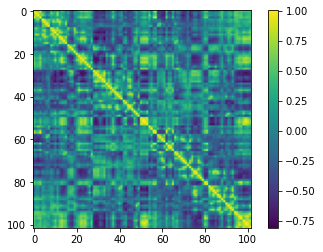

In [8]:
cov = np.cov(data_eq_248_std.T)

plt.imshow(cov)
plt.colorbar()

1 1) vi. What does the off-diagonal activation imply about the independence of the signals measured by the 102 sensors? 

#Write something smart here

1 1) vii. Run `np.linalg.matrix_rank` on the covariance matrix - what integer value do you get? (we'll use this later)  

In [9]:
rank_val = np.linalg.matrix_rank(cov)
print(rank_val)

97


1 1) viii. Find the eigenvalues and eigenvectors of the covariance matrix using `np.linalg.eig` - note that some of the numbers returned are complex numbers, consisting of a real and an imaginary part (they have a _j_ next to them). We are going to ignore this by only looking at the real parts of the eigenvectors and -values. Use `np.real` to retrieve only the real parts  

In [10]:
#If get no complex number, because of my specific hardware

eig_val, eig_vec = np.linalg.eig(cov)


### 2) Create the weighting matrix $W$ and the projected data, $Z$

1 2) i. We need to sort the eigenvectors and eigenvalues according to the absolute values of the eigenvalues (use `np.abs` on the eigenvalues).  

In [11]:
eig_val_pos = np.abs(eig_val)

1 2) ii. Then, we will find the correct ordering of the indices and create an array, e.g. `sorted_indices` that contains these indices. We want to sort the values from highest to lowest. For that, use `np.argsort`, which will find the indices that correspond to sorting the values from lowest to highest. Subsequently, use `np.flip`, which will reverse the order of the indices. 

In [12]:
sorted_indices = np.argsort(eig_val_pos)
sorted_indices_flip = np.flip(sorted_indices)

1 2) iii. Finally, create arrays of sorted eigenvalues and eigenvectors using the `sorted_indices` array just created. For the eigenvalues, it should like this `eigenvalues = eigenvalues[sorted_indices]` and for the eigenvectors: `eigenvectors = eigenvectors[:, sorted_indices]`

In [13]:
eig_val_sort = eig_val_pos[sorted_indices_flip]
eig_vec_sort = eig_vec[sorted_indices_flip]

1 2) iv. Plot the log, `np.log`, of the eigenvalues, `plt.plot(np.log(eigenvalues), 'o')` - are there some values that stand out from the rest? In fact, 5 (noise) dimensions have already been projected out of the data - how does that relate to the matrix rank (Exercise 1.1.vii)  

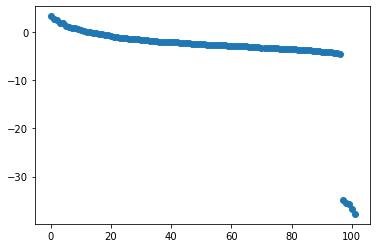

In [14]:
plt.plot(np.log(eig_val_sort), 'o')

#Write smart stuff here

1 2) v. Create the weighting matrix, `W` (it is the sorted eigenvectors)  

In [15]:
W = eig_vec

1 2) vi. Create the projected data, `Z`, $Z = XW$ - (you can check you did everything right by checking whether the $X$ you get from $X = ZW^T$ is equal to your original $X$, `np.isclose` may be of help)

In [16]:
Z = data_eq_248_std @ W

In [17]:
#checking whether I did it the right way
X_check = Z @ W.T
np.unique(np.isclose(data_eq_248_std, X_check), return_counts = True)

(array([ True]), array([40392]))

There are no instances of "False" from isclose function, therefore our weighting matrix is working perfectly.

1 2) vii. Create a new covariance matrix of the principal components (n=102) - plot it! What has happened off-diagonal and why?

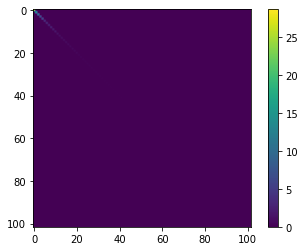

In [18]:
cov_pca = np.cov(Z.T)

plt.imshow(cov_pca)
plt.colorbar()

#Write smart stuff here

# EXERCISE 2 - Use logistic regression with cross-validation to find the optimal number of principal components  

1) We are going to run logistic regression with in-sample validation 

2 1) i. First, run standard logistic regression (no regularization) based on $Z_{d \times k}$ and `y` (the target vector). Fit (`.fit`) 102 models based on: $k = [1, 2, ..., 101, 102]$ and $d = 102$. For each fit get the classification accuracy, (`.score`), when applied to $Z_{d \times k}$ and $y$. This is an in-sample validation. Use the solver `newton-cg` if the default solver doesn't converge

In [19]:
from sklearn.linear_model import LogisticRegression

scores = np.zeros(Z.shape[1]-1)
js = np.zeros(Z.shape[1]-1)

for i in range(Z.shape[1]-1):
    j = i + 1
    log_model = LogisticRegression(penalty='none', random_state=12, solver = 'newton-cg')
    log_model.fit(Z[:,0:j], y_eq)
    scores[i] = log_model.score(Z[:,0:j], y_eq)
    js[i] = j
    

2 1) ii. Make a plot with the number of principal components on the _x_-axis and classification accuracy on the _y_-axis - what is the general trend and why is this so?

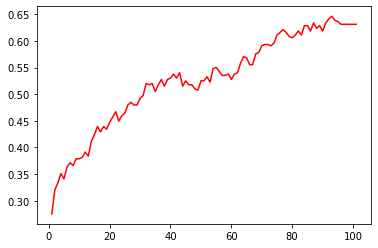

In [20]:
plt.plot(js, scores, 'r')

In [84]:
print((scores[np.argmax(scores)] * 100).round(2), "percent is the highest classification accuracy with", int(js[np.argmax(scores)]), "principal components")


64.65 percent is the highest classification accuracy with 93 principal components


#Maybe fancy text here?

2 1) iii. In terms of classification accuracy, what is the effect of adding the five last components? Why do you think this is so?

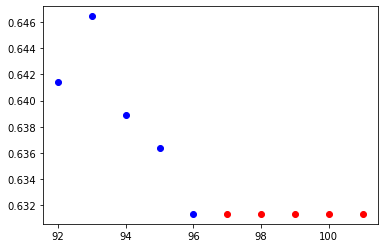

In [44]:
plt.plot(js[-10:-5], scores[-10:-5], 'o', color = 'b')
plt.plot(js[-5:], scores[-5:], 'o', color = 'r')

In [45]:
eig_val[-6:]

array([ 2.49751605e-02,  3.45239558e-16, -6.92000903e-16, -2.94092253e-16,
       -1.14072090e-16, -3.88413109e-17])

As can be seen in the plot above, the effect of adding the last five principal components does not change the classification accuracy at all. It is caused by the fact that the variance in the last 5 principal components dimensions are very small. The effect of the last five components can also be seen by looking at the last five eigen-values showing that the vectors have very little importance. 

2)Now, we are going to use cross-validation - we are using `cross_val_score` and `StratifiedKFold` from `sklearn.model_selection`

2 2) i. Define the variable: `cv = StratifiedKFold()` and run `cross_val_score` (remember to set the `cv` argument to your created `cv` variable). Use the same `estimator` in `cross_val_score` as in Exercise 2.1.i. Find the mean score over the 5 folds (the default of `StratifiedKFold`) for each $k$, $k = [1, 2, ..., 101, 102]$  

In [48]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

#as I showed in the last assignment, cross_val_score uses StratifiedKFold as default, so no need to specify it

k = 5
cv_scores = np.zeros((Z.shape[1]-1, k))
js = np.zeros(Z.shape[1]-1)

for i in range(Z.shape[1]-1):
    j = i + 1
    log_model_cv = LogisticRegression(penalty='none', random_state=12, solver = 'newton-cg')
    cv_scores[i,:] = cross_val_score(log_model_cv, Z[:,0:j], y_eq , cv = k)
    js[i] = j

print(np.mean(cv_scores, axis = 1).round(5))

0.30253


2 2) ii. Make a plot with the number of principal components on the _x_-axis and classification accuracy on the _y_-axis - how is this plot different from the one in Exercise 2.1.ii?

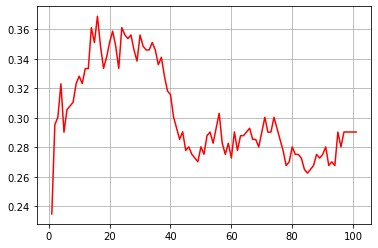

In [62]:
plt.plot(js, np.mean(cv_scores, axis = 1), 'r')
plt.grid(visible = True)

In the other plot the models classification accuracy was tested with the same data as they were trained on. In that case it is hard to assess overfitting. In this plot the models classification accuracy is calculated on the basis of cross validation, which means the models have not been trained on data used for validation. We therefore see a peak in predictive performance at just around 16 principal components. The drop in accuracy after 30 principal components would suggest serious overfitting. From this we can therefore see that the high accuracy scores visualised by the other plot was a result of overfitting the training data.

2 2) iii. What is the number of principal components, $k_{max\_accuracy}$, that results in the greatest classification accuracy when cross-validated?  

In [76]:
idx = np.argmax(np.mean(cv_scores, axis = 1))
k_max_acc = js[idx]

print(int(k_max_acc), 
      "number of principal components results in a classification accuracy of", 
      (np.mean(cv_scores, axis = 1)[idx]*100).round(2), "percent.")

16 number of principal components results in a classification accuracy of 36.88 percent.


2 2) iv. How many percentage points is the classification accuracy increased with relative to the to the full-dimensional, $d$, dataset 

In [77]:
#small question: he does not mean the original dataset, right?

(np.mean(cv_scores, axis = 1)[idx] - np.mean(cv_scores, axis = 1)[-1])*100

7.851265822784809

2 2) v. How do the analyses in Exercises 2.1 and 2.2 differ from one another? Make sure to comment on the differences in optimization criteria.  

###TALK should I use the word "optimization criteria" more? And what is this?

Well, as already written above, the analyses in Exercise 2.1 and 2.2 basically only differ by the fact that in Exercise 2.1 we test the models on already seen data (in-sample validation by testing on training data), while in Exercise 2.2 we test the model on new data thus better assessing the generalisability of the model. Because of this fundamental difference between the two analyses, they each arrive at different conclusions about, what the highest possible classification accuracy is, and how many principal components should be included in that model. The optimization criteria thus makes the conclusion in Exercise 2.1 that 64.65% is the highest possible classification accuracy with 93 principal components, while for exercise 2.2 16 number of principal components was thebest performing with an accuracy of 36.88%.

3)We now make the assumption that $k_{max\_accuracy}$ is representative for each time sample (we only tested for 248 ms). We will use the PCA implementation from _scikit-learn_, i.e. import `PCA` from `sklearn.decomposition`.

i. For __each__ of the 251 time samples, use the same estimator and cross-validation as in Exercises 2.1.i and 2.2.i. Run two analyses - one where you reduce the dimensionality to $k_{max\_accuracy}$ dimensions using `PCA` and one where you use the full data. Remember to scale the data (for now, ignore if you get some convergence warnings - you can try to increase the number of iterations, but this is not obligatory)  

In [90]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [121]:
data_eq, y_eq = equalize_targets(data, y)
cv_scores_all = np.zeros((data_eq.shape[2]))
cv_scores_16 = np.zeros((data_eq.shape[2]))

for d in range(data_eq.shape[2]):
    scaler = StandardScaler()
    data_eq_std = scaler.fit_transform(data_eq[:,:,d])
    
    PCA_all = PCA(random_state = 12)
    Z = PCA_all.fit_transform(data_eq_std)
    k = 5
    log_model_cv = LogisticRegression(penalty='none', random_state=12, solver = 'newton-cg')
    cv_scores_all[d] = np.mean(cross_val_score(log_model_cv, Z, y_eq , cv = k))
    
    PCA_all = PCA(n_components = 16, random_state = 12)
    Z = PCA_all.fit_transform(data_eq_std)
    k = 5
    log_model_cv = LogisticRegression(penalty='none', random_state=12, solver = 'newton-cg')
    cv_scores_16[d] = np.mean(cross_val_score(log_model_cv, Z, y_eq , cv = k))


/Users/nielskrogsgaard/opt/miniconda3/envs/spyder-env/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/nielskrogsgaard/opt/miniconda3/envs/spyder-env/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/nielskrogsgaard/opt/miniconda3/envs/spyder-env/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/nielskrogsgaard/opt/miniconda3/envs/spyder-env/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/nielskrogsgaard/opt/miniconda3/envs/spyder-env/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-

2 3) ii. Plot the classification accuracies for each time sample for the analysis with PCA and for the one without in the same plot. Have time (ms) on the _x_-axis and classification accuracy on the _y_-axis 

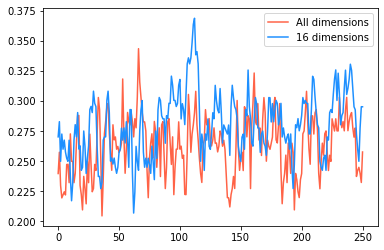

In [127]:
plt.plot(np.arange(0,251,1), cv_scores_all, '-', color = 'tomato', label = "All dimensions")
plt.plot(np.arange(0,251,1), cv_scores_16, '-', color = 'dodgerblue', label = "16 dimensions")
plt.legend()

2 3) iii. Describe the differences between the two analyses - focus on the time interval between 0 ms and 400 ms - describe in your own words why the logistic regression performs better on the PCA-reduced dataset around the peak magnetic activity  

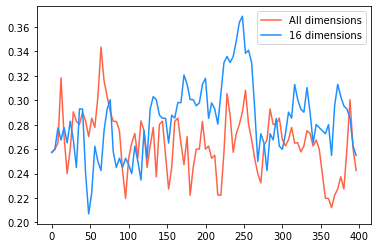

In [137]:
idx_0 = np.argwhere(times == 0).item()
idx_400 = np.argwhere(times == 400).item()

plt.plot(times[idx_0:idx_400], cv_scores_all[idx_0:idx_400], '-', color = 'tomato', label = "All dimensions")
plt.plot(times[idx_0:idx_400], cv_scores_16[idx_0:idx_400], '-', color = 'dodgerblue', label = "16 dimensions")
plt.legend()

In [140]:
cv_all = np.mean(cv_scores_all)
cv_16 = np.mean(cv_scores_16)
print(cv_all, cv_16)

0.2631799384739523 0.2796851833173634


Describe the differences between the two analyses - focus on the time interval between 0 ms and 400 ms - describe in your own words why the logistic regression performs better on the PCA-reduced dataset around the peak magnetic activity

The overall performance over time visually seems to be slightly better when using only 16 dimensions as compared to using all dimensions. A numerical investigation into this shows that the mean of the cross validation of all time samples are very similar between the two methods, however just slightly higher when using 16 dimensions. 
A visual investigation into the time interval between 0 ms and 400 ms shows clearly that 16 dimensions is performing much better here, with a high peak of 37% accuracy. The location of the peak performance corresponds to the time of peak magnetic activity. This makes sense, because as we saw in the last assignment, here it is actually possible to distinguish the different PAS-ratings quite clearly, making the logistic regression better able to classify the PAS-ratings.

#But niels, why does this make sense after applying PCA? Because axis of most variation is probably related to this